# Full Archive Search

- Coppying form this github page https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/master/Full-Archive-Search/full-archive-search.py

In [1]:
from twitter_scraper import TwitterScraper
import pandas as pd
import os
pd.set_option('display.max_colwidth', None)

# Import key from environment variable to keep my credentials secret
bearer_token = os.environ["twitter_bearer_token"]


In [2]:
start_date = "2019-09-30T21:00:00.00Z"
end_date = "2019-11-01T00:00:00.00Z"

ts = TwitterScraper(bearer_token)

TwitterScraper v0.1 initialised.


In [3]:
%%time
df_farage = ts.get_users_tweets(["nigel_farage"],start_date, end_date)
df_farage

------------------------------
User: nigel_farage Number: 1 of 1
------------------------------



<Response [403]>


Exception: (403, '{"client_id":"21045550","detail":"When authenticating requests to the Twitter API v2 endpoints, you must use keys and tokens from a Twitter developer App that is attached to a Project. You can create a project via the developer portal.","registration_url":"https://developer.twitter.com/en/docs/projects/overview","title":"Client Forbidden","required_enrollment":"Appropriate Level of API Access","reason":"client-not-enrolled","type":"https://api.twitter.com/2/problems/client-forbidden"}')

# Chilian News sources

### So far these are the sources that have been identified as potentially interesting:

- @meganoticiascl
- @Cooperativa
- @biobio
- @elmostrador
- @publimetroChile
- @CNNChile
- @adnradiochile
- @T13

In terms of the time period, if you could look between October 18, 2019 and November 18, 2019, that would be some cool gravy.


In [ ]:
%%time

# Chilean summer used in October is timezone CLST (UTC-3 hours)
chilie_start_date = "2019-10-00T21:00:00.00-03:00"
chilie_end_date = "2019-11-01T00:00:00.00-03:00"

chile_news_users = [
    'meganoticiascl',
    'Cooperativa',
    'biobio',
    'elmostrador',
    'publimetroChile',
    'CNNChile',
    'adnradiochile',
    'T13',
]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


In [ ]:
# Try getting just the dates we want in 2019
results = ts.get_users_tweets(chile_news_users, start_date, end_date)

------------------------------
User: meganoticiascl Number: 1 of 8
------------------------------

Tweet 0 from 2019-10-31T23:37:59.000Z
Tweet 100 from 2019-10-31T00:13:01.000Z
Tweet 200 from 2019-10-30T12:05:03.000Z
Tweet 300 from 2019-10-29T20:29:22.000Z
Tweet 400 from 2019-10-29T01:38:08.000Z
Tweet 500 from 2019-10-28T16:37:15.000Z
Tweet 600 from 2019-10-28T01:43:23.000Z
Tweet 700 from 2019-10-27T06:45:00.000Z
Tweet 800 from 2019-10-26T10:32:22.000Z
Tweet 900 from 2019-10-25T16:06:54.000Z
Tweet 1000 from 2019-10-24T21:35:03.000Z
Tweet 1100 from 2019-10-24T08:30:00.000Z
Tweet 1200 from 2019-10-23T16:34:46.000Z
Tweet 1300 from 2019-10-23T02:00:10.000Z
Tweet 1400 from 2019-10-22T16:00:15.000Z
Tweet 1500 from 2019-10-22T04:08:46.000Z
Tweet 1600 from 2019-10-21T14:41:24.000Z
Tweet 1700 from 2019-10-21T00:14:12.000Z
Tweet 1800 from 2019-10-20T16:02:30.000Z
Tweet 1900 from 2019-10-20T03:44:29.000Z
Tweet 2000 from 2019-10-19T19:03:04.000Z
Tweet 2100 from 2019-10-19T11:54:59.000Z
Tweet 2200 

In [ ]:
results

,User,TweetCreated,TweetId,Link,Contents
0,meganoticiascl,2019-10-31T23:37:59.000Z,1190050315481100293,https://twitter.com/meganoticiascl/status/1190050315481100293,Manifestantes con disfraces se toman la marcha en Plaza Italia\n\nhttps://t.co/VU7aap0X5B
1,meganoticiascl,2019-10-31T23:06:40.000Z,1190042433117024256,https://twitter.com/meganoticiascl/status/1190042433117024256,🔴 LO ÚLTIMO: Ahora varias manifestaciones a lo largo del país. https://t.co/TpZViQBTyS
2,meganoticiascl,2019-10-31T23:03:55.000Z,1190041740457250816,https://twitter.com/meganoticiascl/status/1190041740457250816,"Marcelo Salas y movilizaciones sociales: ""Lo que reclama el pueblo chileno es justo""\n\nhttps://t.co/m8EIxWbSUg"
3,meganoticiascl,2019-10-31T22:38:04.000Z,1190035237050474497,https://twitter.com/meganoticiascl/status/1190035237050474497,Nueva jornada de masivas marchas en Santiago y en varias regiones del país\n\nhttps://t.co/dDCk49b2u4
4,meganoticiascl,2019-10-31T22:21:32.000Z,1190031075885690881,https://twitter.com/meganoticiascl/status/1190031075885690881,Sismo afecta a la zona central del país\n\nhttps://t.co/IppeRoU27J
...,...,...,...,...,...
36693,T13,2019-09-30T21:37:07.000Z,1178785874751971337,https://twitter.com/T13/status/1178785874751971337,"Qué es el ""fraude del CEO"" con el que hackers han robado US$26.000 millones de empresas desde 2016 » https://t.co/l7VQpVZekH https://t.co/gcUnnrG17a"
36694,T13,2019-09-30T21:27:52.000Z,1178783544186937344,https://twitter.com/T13/status/1178783544186937344,EN VIVO 🥇 | Comienzan los 200 metros femeninos en #DohaXEl13. No te pierdas los detalles por https://t.co/LVOlKAiNdt https://t.co/qL34HuIyaT
36695,T13,2019-09-30T21:27:18.000Z,1178783400536236033,https://twitter.com/T13/status/1178783400536236033,Centro Sismológico explica últimos temblores registrados en Chile » https://t.co/xVfPJNNOrj https://t.co/aNSgDvAAoo
36696,T13,2019-09-30T21:17:22.000Z,1178780901670604802,https://twitter.com/T13/status/1178780901670604802,EN VIVO 🥇 | Arrancan los 3 mil metros con obstáculos femenino en #DohaXEl13. No te pierdas los detalles por https://t.co/PTXFkXWJpb https://t.co/JRc1eYRaI2


In [ ]:
# Convert to string
df = pd.read_csv('chile_news_2019_10_01_to_2019_11_01_with_link.csv')
df.TweetId = df.TweetId.astype(str)
df.to_csv("chile_news_2019_10_01_to_2019_11_01_with_link.csv")

In [ ]:
df = pd.read_csv("./chile_news_2019_10_01_to_2019_11_01.csv")

FileNotFoundError: [Errno 2] No such file or directory: './chile_news_2019_10_01_to_2019_11_01.csv'

<Axes: xlabel='User', ylabel='Tweet count'>

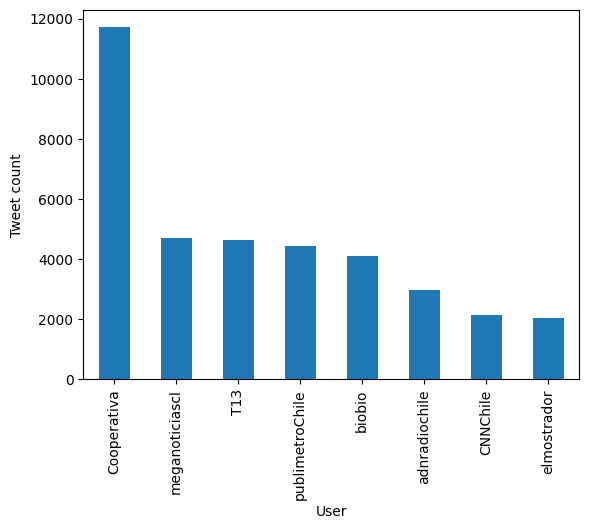

In [ ]:
results['User'].value_counts().plot(kind="bar", ylabel="Tweet count")